In [70]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 20 09:42:10 2020

@author: rhoover
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from t_svd import *
from networkx.generators.community import LFR_benchmark_graph
from networkx.linalg import *

##  Tensor packages for Tucker, etc.  ###
from sktensor.tucker import hooi
from sktensor import dtensor

### Standard Linear Algebra Package  ###
import scipy
import scipy.optimize


from sympy import *

In [22]:
plt.close()

N = 20 # Time steps
n = 20 # Nodes
p = .4
c = 2

adj = np.zeros([n,n,2*N+2])

In [23]:
# Create random graph and store to the last lateral slice of adj
G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,0] = G_adj # Stoer the first adjacency matrix in the first frontal slice of adj

In [24]:
# Create another random graph and store to the last lateral slice of adj
#G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
#G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,(2*N+2) - 1] = G_adj # Store the last adjacency matrix in the last frontal slice of adj

In [25]:
#  Generate graph community over 20 graphs.
for i in range(1,N+1):
    q = p-p*i/(N+1)
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/c),int(n/c)],P))
    adj[0:n,0:n,i] = Gsbm
    #print(i)

In [26]:
###  Generate back end (from communities to single community) - and plot in the loop
eps = 0.0
print('The j vector')
for j in range(1,N+2):
    q = p*(j-1)/(N+2) + eps#remove the eps for complete dissconnectivity #
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/c),int(n/c)],P))
    adj[0:n,0:n,i+j] = Gsbm
    #print(i+j)

The j vector


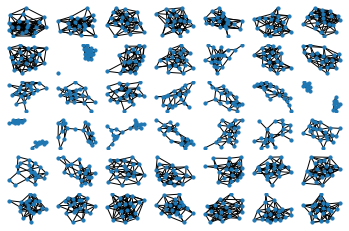

In [27]:
####  Visualization of the graphs
plt.figure(1)
for i in range(2*N+2):
    plt.subplot(6,7,i+1)
    nx.draw(nx.from_numpy_matrix(adj[0:n,0:n,i]),node_size = 10)

In [28]:
lap = laplacian_matrix(nx.from_numpy_matrix(adj[:, :, 21]))
lap = lap.toarray()

# General Process
Let X be the matrix we want the jordan form of
1) SVD(X)

2) Get the # of L.I. Eigenvectors

- The number of L.I. Eigenvectors is the # of Communities (in theory) 

3) Find the general Eigenvectors

4) Profit?


In [158]:
X = np.array(
    [
        [3, 1, 0 ,1],
        [-1, 5, 4, 1],
        [0, 0, 2, 0],
        [0, 0, 0, 4]
    ])

X = adj[:,:,21]
X = lap

In [159]:
# Step 2
lambdas, v = np.linalg.eig(X)
print("Eigen Vals:", lambdas.real) 
lambdas = np.where(abs(lambdas) > .00001, lambdas,  0)
#lambdas = np.around(lambdas, 5)



# Get Algebreic multiplicities
unique_values, algebreic_multiple = np.unique(lambdas, return_counts=True)

geometric_multiple = np.zeros(unique_values.shape)

print("Unique Vals:", unique_values)
print("Algebreic Multiplicites:", algebreic_multiple)


# Get Geometric Multiplicites for all unique eigen vals
for s in unique_values:
    index = np.where(unique_values == s)
    kernel = X - (s * np.identity(X.shape[1]))
    geometric_multiple[index] = scipy.linalg.null_space(kernel).shape[1]
    
print("Geometric Multiplities:", geometric_multiple) 

Eigen Vals: [-1.11022302e-15  6.58412623e-01  7.66218496e+00  7.19662146e+00
  6.59553264e+00  4.93624054e+00  2.41842631e+00  3.34514630e+00
  3.18743516e+00  4.00000000e+00 -1.33226763e-15  1.36261528e+00
  7.09676136e+00  2.02131516e+00  2.74592459e+00  3.37760379e+00
  4.25171935e+00  6.24295546e+00  5.07868022e+00  5.82242480e+00]
Unique Vals: [0.         0.65841262 1.36261528 2.02131516 2.41842631 2.74592459
 3.18743516 3.3451463  3.37760379 4.         4.25171935 4.93624054
 5.07868022 5.8224248  6.24295546 6.59553264 7.09676136 7.19662146
 7.66218496]
Algebreic Multiplicites: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Geometric Multiplities: [2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [152]:
J = np.zeros(X.shape)
block_start = 0
for s in unique_values:
    index = np.where(unique_values == s) 
    a = algebreic_multiple[index][0]
    np.fill_diagonal(J[block_start:block_start+a, block_start:block_start+a], s)
    
    block_start += a

print(J.diagonal())

[0.         0.         0.65841262 1.36261528 2.02131516 2.41842631
 2.74592459 3.18743516 3.3451463  3.37760379 4.         4.25171935
 4.93624054 5.07868022 5.8224248  6.24295546 6.59553264 7.09676136
 7.19662146 7.66218496]
